# Finding optimal values for A1 and A2 coefficients </a><a name='top'>

Given an "ideal" initial snow density, we try to determine what is the best pair of (A1, A2) coefficients, using 3 different metrics.

Parameters are defined in the file **parameter.py**, to be adjusted before launching the notebook, but additional information must be filled in in [**this section**](#fill-in). Once these two sections are filled in, the whole notebook may be run.
    
Once the ranges of parameters are satisfactory, define the optimal curve to plot [**here**](#opt).

## Imports and functions

In [1]:
from joblib import Parallel, delayed
import math
from scipy.stats import sem
from matplotlib.patches import Rectangle

In [2]:
%run little_awk_functions.py
%run parameters.py

In get_met_forcing() - Warning: check the format of your file corresponds to the indices given in the functions (wind speed 5, surface temperature 7, time 0).


In [3]:
def single_simulation(data_set_used, x_isel, y_isel, max_nb_of_layers, data_duration_in_s, ds_time_indices, end_accumulation_times, end_erosion_times, start_accumulation, end_accumulation, 
                      start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2,
                      met_temp, met_wind, met_time):
    '''
    Function that uses the simulate_snowpack_evolution() function to simulate the snowpack's evolution for a given (a1, a2) pair
    Args:
        data_duration_in_s: total duration of the lidar data, in seconds
        ds_time_indices: indices of the simulation that correspond to the lidar data (and should thus be the only to be kept)
        for all other arguments, please refer to the simulate_snowpack_evolution() docstring
    Returns:
        an np-array containing:
        a1, a2: unchanged values, used for identification of the results
        total_snow_depth: array containing the depth of the snowpack at each timestamp
    '''
    nb_iterations = int(data_duration_in_s/dt + 1)

    # Update variables at each timepoint

    snowpack = simulate_snowpack_evolution(data_set_used, x_isel, y_isel, nb_iterations, max_nb_of_layers, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp, met_wind_data=met_wind,
                                       met_time_data=met_time)

    ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]
     
    # Define total_snow_depth

    total_snow_depth = np.array([sum(depth_evolution[i][j] for j in range(max_nb_of_layers)) for i in range(len(depth_evolution)) if i in ds_time_indices])
    
    return(np.array([a1, a2, total_snow_depth], dtype=object))

In [4]:
def parallel_simulation(data_set_used, x_isel, y_isel, max_nb_of_layers, data_duration_in_s, ds_time_indices, end_accumulation_times, end_erosion_times, start_accumulation, end_accumulation, 
                      start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1_range, a2_range,
                      met_temp, met_wind, met_time):
    '''
    Function that runs single_simulation() in parallel for a range of values of a1 and a2
    Args:
        data_duration_in_s: total duration of the lidar data, in seconds
        ds_time_indices: indices of the simulation that correspond to the lidar data (and should thus be the only to be kept)
        for all other arguments, please refer to the simulate_snowpack_evolution() docstring
    Returns:
        p_s: array containing the [a1, a2, total_snow_depth] results computed for each pair of (a1, a2) arguments
    '''
    a1_a2_range = [(a1, a2) for a1 in a1_range for a2 in a2_range]
    
    # Run a simulation for each pair of (a1, a2)

    p_s = Parallel(n_jobs=-2)(delayed(single_simulation)(data_set_used, x_isel, y_isel, max_nb_of_layers, data_duration_in_s, ds_time_indices, end_accumulation_times, end_erosion_times,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow,
                      melt_flag, a1, a2, met_temp, met_wind, met_time) for (a1, a2) in a1_a2_range)
    
    return(np.array(p_s, dtype=object))

In [5]:
def parallel_measures(parallel_simulations_array, lidar_height_array):
    '''
    Function that runs all_measures() in parallel for a range of values of a1 and a2
    Args:
        parallel_simulations_array: array containing the [a1, a2, total_snow_depth] results of simulations computed for each pair of (a1, a2) arguments
        lidar_height_array: array containing the depth of the snowpack as measured by the lidar, corresponding to each simulation timestamp
    Returns:
        p_m: array containing the [a1, a2, (rmse, stde, p_corr)] measure results computed for each pair of (a1, a2) arguments
    '''
    p_m = Parallel(n_jobs=-2)(delayed(all_measures)(parallel_simulations_array[i][0], parallel_simulations_array[i][1], parallel_simulations_array[i][2], lidar_height_array)  # a1, a2, simul_total_height_array
                       for i in range(len(parallel_simulations_array)))
    
    return(p_m)

## Define default parameters </a><a name='fill-in'>

In [6]:
# Dataset

name_of_data_set = 'pit_7_2023.nc'

save_figures = False
directory_to_save_figs_in = '/home/mabonnet/github/MB_little_awk/finalized/Results_pits_2023/'
fig_name_1 = 'pit_7_A1_A2_metrics.png'
fig_name_2 = 'pit_7_A1_A2_curves.png'

In [7]:
# Values of a1 and a2 to be tested

a1_range = np.linspace(0, 0.002, num=9, endpoint=True)
a2_range = np.linspace(0.005, 0.035, num=9, endpoint=True)

[Back to top section](#top)

## Clean dataset and derive other parameters

In [8]:
# Pre-processing to get clean data

data_set_used = xr.open_dataset(name_of_data_set)

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7, y_span=7)
median_time_filtering(data_set_used, 11)

# Add the summer surface to the dataset

define_summer_surface(data_set_used, start_summer_surface, end_summer_surface)

# Redefine the zero of the dataset

data_set_used['snow_depth'] = data_set_used['snow_surface'] - data_set_used['summer_surface']


---> Median filtering in space with a window [7, 7]
---> Median filtering in time with a window of 11
---> Summer surface defined based on scans from 2022-10-07 to 2022-10-15


In [9]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

data_start_date = pd.to_datetime(data_set_used.time.values[0])

In [10]:
# Snow events detection

results = get_snow_events(data_set_used, x_isel, y_isel, time_window_std, std_threshold)
start_accumulation, start_erosion, end_accumulation, end_erosion = results[0], results[1], results[2], results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

In [11]:
# Create comparable data between lidar and simulation (same timestamps)

lidar_height_array = []
keep_simul_times_indices = []    # indices of the timestamps to keep in the simulation data, that are comparable to the lidar data
                                # given that dt << lidar scans time period, there are no repetitions in keep_simul_times_indices

ignore = np.isnan(data_set_used.snow_depth.isel(x=x_isel, y=y_isel))     # do not take into account the nan values in the dataset

for index in range(len(data_set_used.time.values)):
        lidar_time_in_s = float(data_set_used.time.values[index]) / 1000000000 - float(data_set_used.time.values[0]) / 1000000000
        if lidar_time_in_s < nb_iterations*dt and not ignore[index]:
            lidar_height_array.append(data_set_used.snow_depth.isel(x=x_isel, y=y_isel, time=index))

            index_of_closest_time_in_simul = int(lidar_time_in_s//dt + round((lidar_time_in_s%dt)/dt))
            keep_simul_times_indices.append(index_of_closest_time_in_simul)

lidar_height_array = np.array(lidar_height_array)

## Loop on parameters A1 and A2

In [13]:
# Run all simulations

simul = parallel_simulation(data_set_used, x_isel, y_isel, max_nb_of_layers, data_duration_in_s, keep_simul_times_indices, end_accumulation_times, end_erosion_times, start_accumulation, end_accumulation, 
                      start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, age_layers, gamma, cp_snow, melt_flag, a1_range, a2_range,
                      met_temp, met_wind, met_time)


In [14]:
# Evaluate all simulations

measrs = parallel_measures(simul, lidar_height_array)


In [15]:
# Print best results for each measure used

for i in range(len(measrs)):
    if measrs[i][2][2] == max(measrs[i][2][2] for i in range(len(measrs))):
        print('Pearson correlation max: ', measrs[i])
    if measrs[i][2][1] == min(measrs[i][2][1] for i in range(len(measrs))):
        print('Std error min: ', measrs[i])
    if measrs[i][2][0] == min(measrs[i][2][0] for i in range(len(measrs))):
        print('RMSE min: ', measrs[i])


Pearson correlation max:  (0.00025, 0.01625, (0.09048583607474597, 0.0008003792185598335, 0.9950004389238953))
Std error min:  (0.0005, 0.01625, (0.06207863243880692, 0.0006014574659033997, 0.9949488036681635))
RMSE min:  (0.0005, 0.01625, (0.06207863243880692, 0.0006014574659033997, 0.9949488036681635))


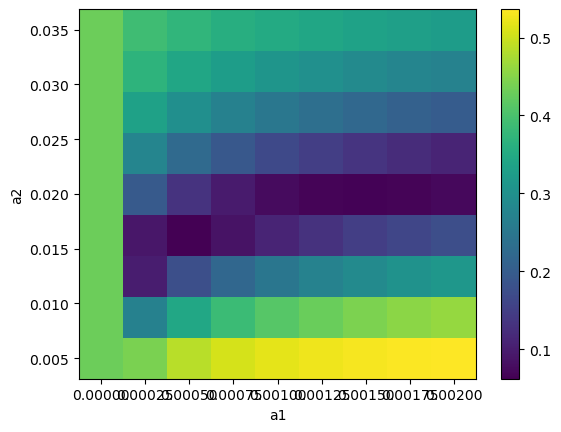

In [16]:
# RMSE measure > min is best

x = a1_range
y = a2_range
z = np.array([measrs[i][2][0] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y)).T

plt.pcolor(X, Y, Z)
plt.xlabel('a1')
plt.ylabel('a2')

plt.colorbar()
plt.show()

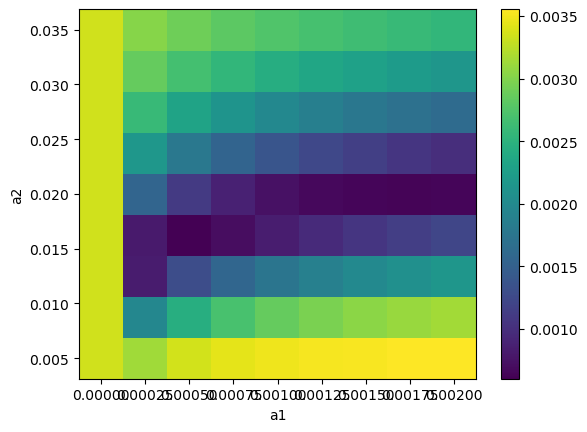

In [17]:
# Std error measure > min is best

x = a1_range
y = a2_range
z = np.array([measrs[i][2][1] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y)).T

plt.pcolor(X, Y, Z)
plt.xlabel('a1')
plt.ylabel('a2')

plt.colorbar()
plt.show()

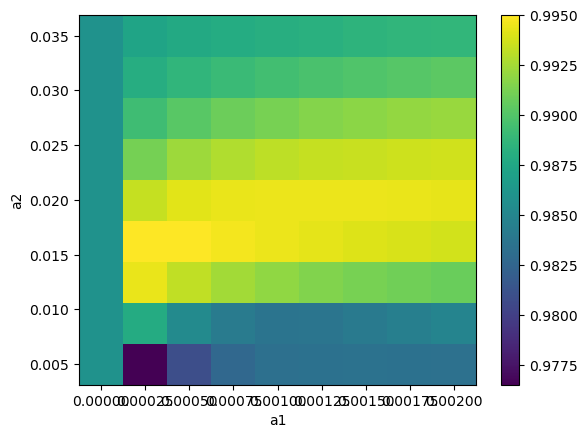

In [18]:
# Pearson correlation measure > max is best

x = a1_range
y = a2_range
z = np.array([measrs[i][2][2] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z = z.reshape(len(x), len(y)).T

plt.pcolor(X, Y, Z)
plt.xlabel('a1')
plt.ylabel('a2')

plt.colorbar()
plt.show()

## Plot results </a><a name='opt'>

In [19]:
# Define useful variables

a1_step = a1_range[1]-a1_range[0]
a2_step = a2_range[1]-a2_range[0]

optimum_coords = [2, 3]

[Back to top section](#top)

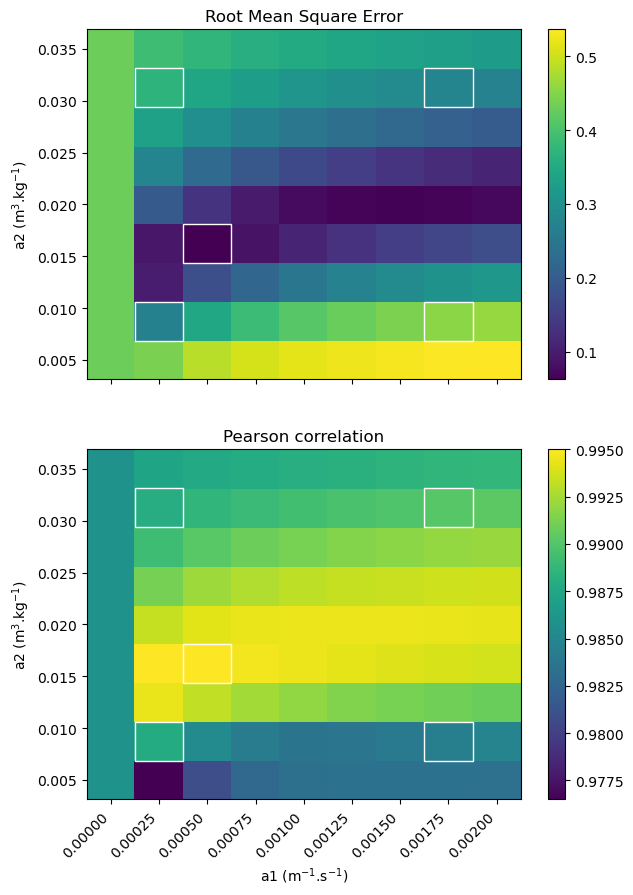

In [20]:
# Plot the results for rmse and correlation measures

fig, axs = plt.subplots(2, 1, figsize=(7, 10))

for ax in axs.flat:
    ax.set(xlabel='a1 (m$^{-1}$.s$^{-1}$)', ylabel='a2 (m$^3$.kg$^{-1}$)')
    ax.label_outer()

plt.xticks(rotation=45, ha="right")

x = a1_range
y = a2_range
z_rmse = np.array([measrs[i][2][0] for i in range(len(measrs))])
z_corr = np.array([measrs[i][2][2] for i in range(len(measrs))])

X, Y = np.meshgrid(x, y)
Z_rmse = z_rmse.reshape(len(x), len(y)).T
Z_corr = z_corr.reshape(len(x), len(y)).T

# Plot the rmse values

fig0 = axs[0].pcolor(X, Y, Z_rmse)
axs[0].set_title('Root Mean Square Error')
fig.colorbar(fig0, ax=axs[0])

# Add rectangles to situate plotted pairs

axs[0].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[0].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[0].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[0].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[0].add_patch(Rectangle((a1_range[optimum_coords[0]] - a1_step/2, a2_range[optimum_coords[1]] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))

# Plot the correlation values

fig1 = axs[1].pcolor(X, Y, Z_corr)
axs[1].set_title('Pearson correlation')
fig.colorbar(fig1, ax=axs[1])

# Add rectangles to situate plotted pairs

axs[1].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[1].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[1].add_patch(Rectangle((a1_range[-2] - a1_step/2, a2_range[1] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[1].add_patch(Rectangle((a1_range[1] - a1_step/2, a2_range[-2] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))
axs[1].add_patch(Rectangle((a1_range[optimum_coords[0]] - a1_step/2, a2_range[optimum_coords[1]] - a2_step/2), a1_step, a2_step, edgecolor='white', facecolor='none', lw=1, ls='-'))


In [21]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name_1)

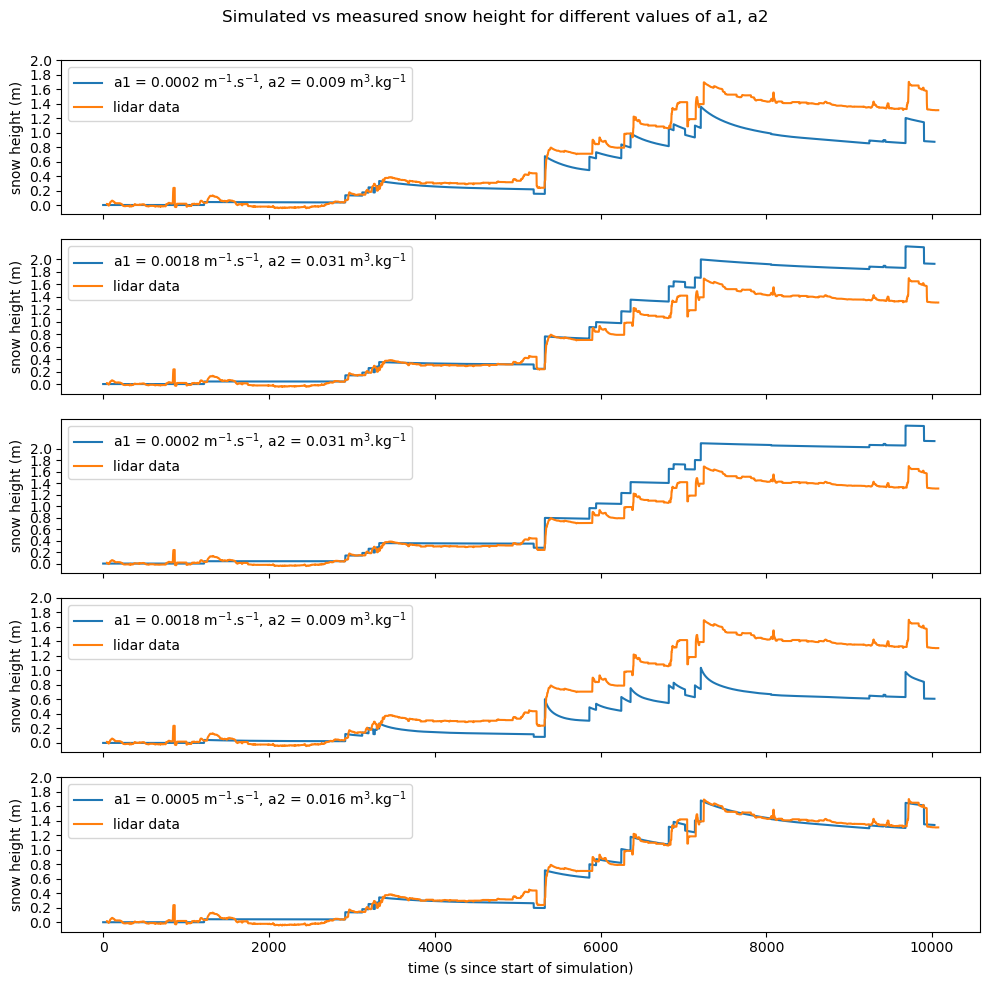

In [22]:
# Plot 5 selected simulation curves

optimum_index = optimum_coords[0]*len(a2_range) + optimum_coords[1]

fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for ax in axs.flat:
    ax.set(xlabel='time (s since start of simulation)', ylabel='snow height (m)')
    ax.label_outer()

axs[0].plot(simul[len(a2_range)+1][2], label='a1 = '+str(round(simul[len(a2_range)+1][0], 4))+' m$^{-1}$.s$^{-1}$, a2 = '+str(round(simul[len(a2_range)+1][1], 3))+' m$^3$.kg$^{-1}$')
axs[0].plot(data_set_used.snow_depth.isel(x=x_isel, y=y_isel), label='lidar data')
axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
axs[0].legend(loc='upper left')

axs[1].plot(simul[-2*len(a2_range)+(len(a2_range)-2)][2], label='a1 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][0], 4))+' m$^{-1}$.s$^{-1}$, a2 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][1], 3))+' m$^3$.kg$^{-1}$')
axs[1].plot(data_set_used.snow_depth.isel(x=x_isel, y=y_isel), label='lidar data')
axs[1].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
axs[1].legend(loc='upper left')

axs[2].plot(simul[len(a2_range)+(len(a2_range)-2)][2], label='a1 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][0], 4))+' m$^{-1}$.s$^{-1}$, a2 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][1], 3))+' m$^3$.kg$^{-1}$')
axs[2].plot(data_set_used.snow_depth.isel(x=x_isel, y=y_isel), label='lidar data')
axs[2].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
axs[2].legend(loc='upper left')

axs[3].plot(simul[-2*len(a2_range)+1][2], label='a1 = '+str(round(simul[-2*len(a2_range)+1][0], 4))+' m$^{-1}$.s$^{-1}$, a2 = '+str(round(simul[-2*len(a2_range)+1][1], 3))+' m$^3$.kg$^{-1}$')
axs[3].plot(data_set_used.snow_depth.isel(x=x_isel, y=y_isel), label='lidar data')
axs[3].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
axs[3].legend(loc='upper left')

axs[4].plot(simul[optimum_index][2], label='a1 = '+str(round(simul[optimum_index][0], 4))+' m$^{-1}$.s$^{-1}$, a2 = '+str(round(simul[optimum_index][1], 3))+' m$^3$.kg$^{-1}$')
axs[4].plot(data_set_used.snow_depth.isel(x=x_isel, y=y_isel), label='lidar data')
axs[4].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
axs[4].legend(loc='upper left')

fig.suptitle('Simulated vs measured snow height for different values of a1, a2')
fig.tight_layout()
fig.subplots_adjust(top=0.93)

In [23]:
if save_figures:
    fig.savefig(directory_to_save_figs_in + fig_name_2)

Text(0.5, 1.0, 'Simulated vs measured snow height for different values of a1, a2')

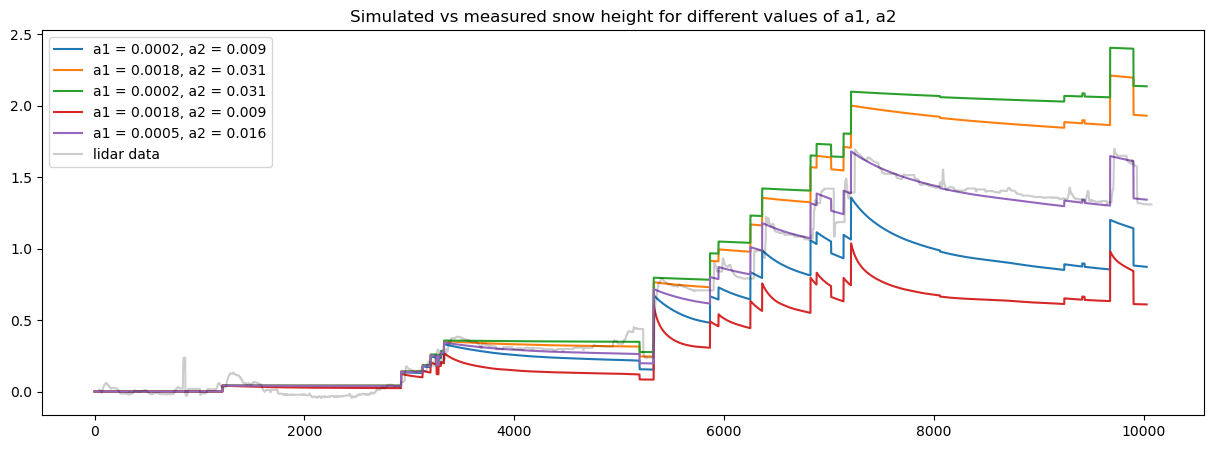

In [24]:
# Other option for presentation of results: all 5 simulation curves on the same graph

optimum_index = optimum_coords[0]*len(a2_range) + optimum_coords[1]

fig = plt.figure(figsize=(15, 5))

fig.xlabel='time'
fig.ylabel='snow height (m)'

plt.plot(simul[len(a2_range)+1][2], label='a1 = '+str(round(simul[len(a2_range)+1][0], 4))+', a2 = '+str(round(simul[len(a2_range)+1][1], 3)))
plt.plot(simul[-2*len(a2_range)+(len(a2_range)-2)][2], label='a1 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][0], 4))+', a2 = '+str(round(simul[-2*len(a2_range)+(len(a2_range)-2)][1], 3)))
plt.plot(simul[len(a2_range)+(len(a2_range)-2)][2], label='a1 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][0], 4))+', a2 = '+str(round(simul[len(a2_range)+(len(a2_range)-2)][1], 3)))
plt.plot(simul[-2*len(a2_range)+1][2], label='a1 = '+str(round(simul[-2*len(a2_range)+1][0], 4))+', a2 = '+str(round(simul[-2*len(a2_range)+1][1], 3)))

plt.plot(simul[optimum_index][2], label='a1 = '+str(round(simul[optimum_index][0], 4))+', a2 = '+str(round(simul[optimum_index][1], 3)))

plt.plot(data_set_used.snow_depth.isel(x=x_isel, y=y_isel), label='lidar data', c='k', alpha=0.2)
plt.legend()

plt.title('Simulated vs measured snow height for different values of a1, a2')
